# Traffic Prediction

## Introduction

Traffic congestion is rising in cities around the world. Contributing factors include expanding urban populations, aging infrastructure, inefficient and uncoordinated traffic signal timing and a lack of real-time data.

This project aims to preict the time of day at which certain junctions are congested based on their historical data from 2015 - 2017.

The data is of 4 junctions..

The data contains 48120 rows and 4 columns

 *   ID        -     The unique ID of the observation
 *   DateTime  -     The date and time the data was recorded
 *   Junction  -
 *   Vehicles  -
ID -  DateTime -  Junction - The junction number Vehicles - Number of vehicles at the junction at a particular time

In [2]:
# Importing libraries used
import pandas as pd
import numpy as np

# The time module allows me to parse and work with datetime data types
import time
from datetime import datetime

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Data Wrangling

In [3]:
# Loading the dataset and viewing the first few rows
df = pd.read_csv("traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [4]:
# This line re-arranges the columns in a preferred order
df = df[["ID", "DateTime", "Junction", "Vehicles"]]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        48120 non-null  int64 
 1   DateTime  48120 non-null  object
 2   Junction  48120 non-null  int64 
 3   Vehicles  48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


The dataset has no null values.

The DateTime column has been wrongly classified as an object. This will be changed to the appropriate data type (datetime[ns]) to...

In [6]:
# Casting the datetime column to the datetime data type
df["DateTime"] = df["DateTime"].astype("datetime64")

In [7]:
# To save memory, the junction and vehicles columns are also changed to int32
df[["Junction", "Vehicles"]] = df[["Junction", "Vehicles"]].astype("int32")

In [8]:
# Taking another look to confirm the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        48120 non-null  int64         
 1   DateTime  48120 non-null  datetime64[ns]
 2   Junction  48120 non-null  int32         
 3   Vehicles  48120 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 1.1 MB


In [10]:
# A statistical overview of the numerical columns
df.describe(include="int32")

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


Average number of vehicles at a junction is 23. 

Let's say the junction has a high traffic density if it has vehicles 29 (75th quartile) and above

Eventually create a label column with observations, high and low

Therefore our model will be a clasification one

In [13]:
# Checking for duplicates
df.duplicated().sum()

0

In [14]:
df.ID.duplicated().sum()

0

In [15]:
# Checking the number of junctions
df['Junction'].unique()

array([1, 2, 3, 4])

In [16]:
df.Junction.value_counts()

3    14592
2    14592
1    14592
4     4344
Name: Junction, dtype: int64

In [20]:
# The first day in the data set
df.DateTime.min()

Timestamp('2015-11-01 00:00:00')

In [21]:
# The last day & time in the data set
df.DateTime.max()

Timestamp('2017-06-30 23:00:00')

In [16]:
# To find the first date where traffic or Junction 4 was recorded
df[df["Junction"] == 4]["DateTime"].min()

Timestamp('2017-01-01 00:00:00')

There are no duplicate rows or ID s.

The junction column has 4 unique values. i.e 4 junctions were studied / surveyed?

Junction 4 has the lowest number of occurences this is because it only has entries from 2017.

To maintain balance, I will be removing all entries for Junction 4

In [8]:
junction_4 = df[df.Junction == 4]
junction_4.head()

,ID,DateTime,Junction,Vehicles
43776,20170101004,2017-01-01 00:00:00,4,3
43777,20170101014,2017-01-01 01:00:00,4,1
43778,20170101024,2017-01-01 02:00:00,4,4
43779,20170101034,2017-01-01 03:00:00,4,4
43780,20170101044,2017-01-01 04:00:00,4,2


In [9]:
df.drop(df[df.Junction == 4].index, inplace=True)

To gain more insight from this dataset, I will create month and hour columns, in order to study the changes in traffic congestion at different times of the day and differentmonths within the year.

In [10]:
# Making a copy of the dataset so the original dataset remains unchanged
new_df = df.copy()

In [11]:
# Create a hour column
new_df["Hour"] = new_df["DateTime"].dt.strftime("%H:%M")

In [12]:
# Create a month column
new_df["Month"] = new_df["DateTime"].dt.strftime("%b, %Y")

In [13]:
# Rearranging columns
new_df = new_df[["ID", "DateTime", "Month", "Hour", "Junction", "Vehicles"]]

In [15]:
# Viewing the new dataset
new_df.head()

,ID,DateTime,Month,Hour,Junction,Vehicles
0,20151101001,2015-11-01 00:00:00,"Nov, 2015",00:00,1,15
1,20151101011,2015-11-01 01:00:00,"Nov, 2015",01:00,1,13
2,20151101021,2015-11-01 02:00:00,"Nov, 2015",02:00,1,10
3,20151101031,2015-11-01 03:00:00,"Nov, 2015",03:00,1,7
4,20151101041,2015-11-01 04:00:00,"Nov, 2015",04:00,1,9


In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        43776 non-null  int64         
 1   DateTime  43776 non-null  datetime64[ns]
 2   Month     43776 non-null  object        
 3   Hour      43776 non-null  object        
 4   Junction  43776 non-null  int32         
 5   Vehicles  43776 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(2)
memory usage: 2.0+ MB


## Exploratory Data Analysis

In [28]:
print("Total number of vehicles at all junctions over the years:", new_df.Vehicles.sum())
print("Average number of vehicles at all junctions per day:", new_df.Vehicles.groupby(new_df["DateTime"].dt.strftime("%Y-%m-%d")).sum().mean())
print("Average number of vehicles at each junction at a time:", new_df.Vehicles.mean())
print("Highest number of vehicles at each junction at a time:", new_df.Vehicles.max())
print("Lowest number of vehicles at each junction at a time:", new_df.Vehicles.min())

Total number of vehicles at all junctions over the years: 1065218
Average number of vehicles at all junctions per day: 1752.0032894736842
Average number of vehicles at each junction at a time: 24.333379020467838
Highest number of vehicles at each junction at a time: 180
Lowest number of vehicles at each junction at a time: 1


In [29]:
# Viewing the totaltraffic each day
new_df.Vehicles.groupby(new_df["DateTime"].dt.strftime("%Y-%m-%d")).sum()

DateTime
2015-11-01     596
2015-11-02     909
2015-11-03     911
2015-11-04     818
2015-11-05     770
              ... 
2017-06-26    2775
2017-06-27    3484
2017-06-28    3303
2017-06-29    3279
2017-06-30    3091
Name: Vehicles, Length: 608, dtype: int32

In [30]:
# Traffic by the hour
new_df.Vehicles.groupby(new_df["Hour"]).sum()

Hour
00:00    45946
01:00    38382
02:00    33415
03:00    28987
04:00    25313
05:00    23694
06:00    25281
07:00    28662
08:00    31943
09:00    37723
10:00    47158
11:00    53498
12:00    55097
13:00    49723
14:00    53877
15:00    53739
16:00    51854
17:00    51790
18:00    54795
19:00    58257
20:00    58163
21:00    55022
22:00    53004
23:00    49895
Name: Vehicles, dtype: int32

In [16]:
# Creating a dataframe that shows total traffic by the junction
junction_volume = pd.DataFrame(new_df.Vehicles.groupby(new_df["Junction"]).sum())
junction_volume

,Vehicles
Junction,
1,657412
2,207983
3,199823


In [17]:
junction_volume = junction_volume.reset_index()

### Univariate Analysis

In [18]:
# Set plot style and figure size
sns.set(style="whitegrid", rc={"figure.figsize":(15, 8)})

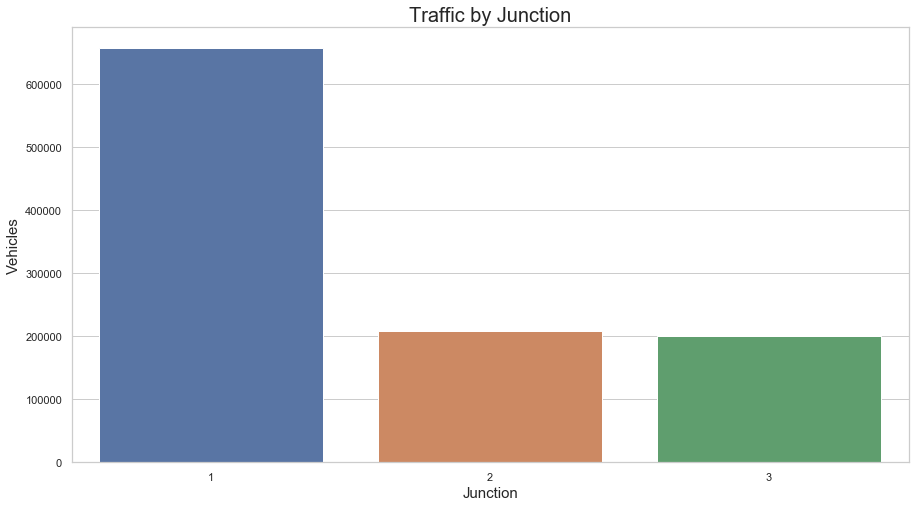

In [38]:
sns.barplot(x="Junction", y="Vehicles", data=junction_volume)

plt.title('Traffic by Junction', fontsize=20)
plt.xlabel('Junction', fontsize=15)
plt.ylabel('Vehicles', fontsize=15);

Junction 1 has the overall highest traffic rate

### Multivariate analysis

In [21]:
new_df.Vehicles.groupby(new_df[["DateTime", "Junction"]].dt.strftime("%Y-%m-%d")).sum()

AttributeError: 'DataFrame' object has no attribute 'dt'

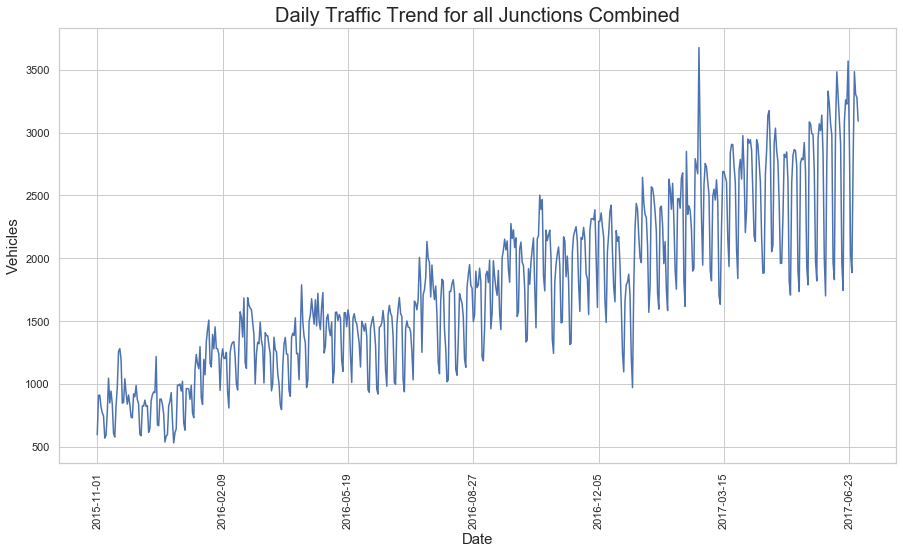

In [47]:
# traffic increases steadily per year.
new_df.Vehicles.groupby(new_df["DateTime"].dt.strftime("%Y-%m-%d")).sum().plot()

plt.title('Daily Traffic Trend for all Junctions Combined', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Vehicles', fontsize=15)

# What is this y-axis??

There's a general upward trend in traffic.

Traffic increases daily

In [70]:
hourly = new_df[["Vehicles", "Hour"]].groupby("Hour").sum().reset_index()
hourly.head()

,Hour,Vehicles
0,00:00,25.189693
1,01:00,21.042763
2,02:00,18.319627
3,03:00,15.891996
4,04:00,13.877741


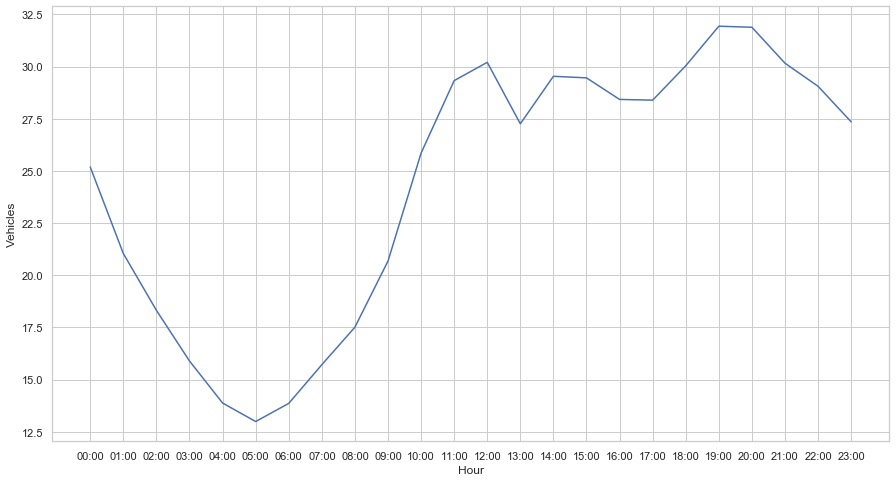

In [72]:
sns.lineplot(x=hourly["Hour"], y=hourly["Vehicles"])

The time of day with the least amount of traffic appears to be 5 am in the morning. It increases gradually and remains steady from 11 am.

The hour with the heaviest traffic is 7 pm.

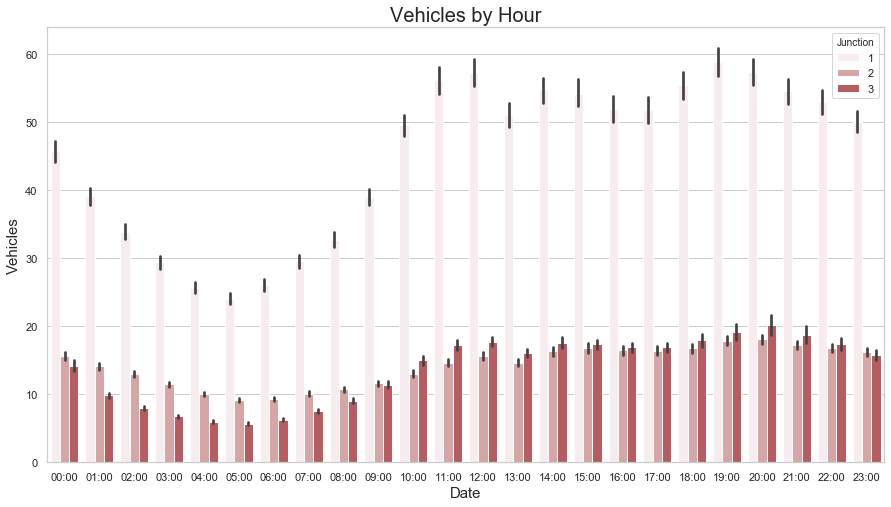

In [74]:
sns.barplot(x="Hour", y="Vehicles", data=new_df, color="r", hue="Junction")

plt.title('Vehicles by Hour', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Vehicles', fontsize=15);

There's a similar trend for all junctions, with Junction 1 having the heaviest traffic overall.

In [43]:
new_df["Junction"].value_counts()

3    14592
2    14592
1    14592
Name: Junction, dtype: int64

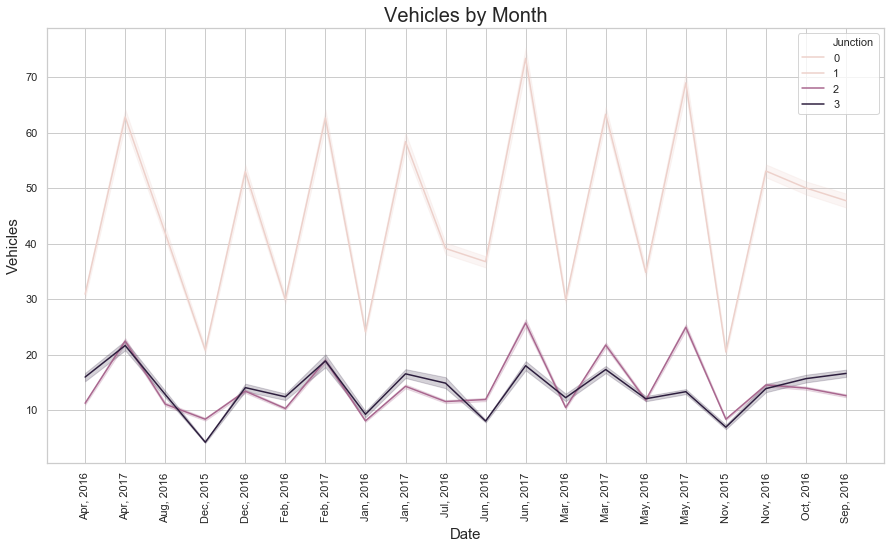

In [22]:
sns.lineplot(x="Month", y="Vehicles", hue="Junction", data=new_df)

plt.xticks(rotation=90);
plt.title('Vehicles by Month', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Vehicles', fontsize=15);

June 2017 was the month with the highest level of traffic in junctions 1 & 2

April 17 was the month with the highest traffic at Junction 3

## Model Building

In [23]:
# Importing libraires for model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [52]:
# Making a copy f the modified dataset
model_data = new_df.copy()

In [82]:
model_data["Vehicles"].describe()

count    43776.000000
mean        24.333379
std         21.112090
min          1.000000
25%         10.000000
50%         17.000000
75%         32.000000
max        180.000000
Name: Vehicles, dtype: float64

In [53]:
# Converting the 'Vehicles' feature to a categorical variable
model_data["Vehicles"] = model_data["Vehicles"].replace([i for i in range(32)], "Low")

model_data["Vehicles"] = model_data["Vehicles"].replace([i for i in range(32, 181)], "High")

In [54]:
model_data["Vehicles"].value_counts()

Low     32744
High    11032
Name: Vehicles, dtype: int64

In [55]:
model_data["Month"] = model_data["DateTime"].dt.strftime("%m")
model_data["Year"] = model_data["DateTime"].dt.strftime("%Y")
model_data["Hour"] = model_data["DateTime"].dt.strftime("%H")
model_data.head()

,ID,DateTime,Month,Hour,Junction,Vehicles,Year
0,20151101001,2015-11-01 00:00:00,11,00,1,Low,2015
1,20151101011,2015-11-01 01:00:00,11,01,1,Low,2015
2,20151101021,2015-11-01 02:00:00,11,02,1,Low,2015
3,20151101031,2015-11-01 03:00:00,11,03,1,Low,2015
4,20151101041,2015-11-01 04:00:00,11,04,1,Low,2015


In [28]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        43776 non-null  int64         
 1   DateTime  43776 non-null  datetime64[ns]
 2   Month     43776 non-null  object        
 3   Hour      43776 non-null  object        
 4   Junction  43776 non-null  int32         
 5   Vehicles  43776 non-null  object        
 6   Year      43776 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 2.5+ MB


In [56]:
# X = model_data[["DateTime", "Junction", "Hour", "Month", "Year"]]
X = model_data[["Junction", "Hour", "Month", "Year"]]
y = model_data["Vehicles"]

## Feature Selection

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [58]:
feats = SelectKBest(score_func=chi2, k=3)
feats.fit_transform(X, y)

array([[1, '00', '11'],
       [1, '01', '11'],
       [1, '02', '11'],
       ...,
       [3, '21', '06'],
       [3, '22', '06'],
       [3, '23', '06']], dtype=object)

In [59]:
pd.DataFrame(feats.scores_, 
             index=X.columns, 
             columns=["feature_score"]).sort_values("feature_score", ascending=False).head(20)

,feature_score
Junction,5040.864303
Hour,4162.617687
Month,212.844193
Year,0.460066


In [60]:
feats2 = SelectKBest(score_func=f_classif, k=3)
feats2.fit_transform(X, y)

array([[1, '00', '2015'],
       [1, '01', '2015'],
       [1, '02', '2015'],
       ...,
       [3, '21', '2017'],
       [3, '22', '2017'],
       [3, '23', '2017']], dtype=object)

In [61]:
pd.DataFrame(feats2.scores_, 
             index=X.columns, 
             columns=["feature_score"]).sort_values("feature_score", ascending=False)

,feature_score
Junction,23102.885461
Year,2745.155394
Hour,1022.313189
Month,99.640511


In [62]:
X = X[["Junction", "Hour"]]

In [63]:
# Encode labels
y = y.replace(["High", "Low"], [1, 0]) # Is this the ideal encoding format for a binary classifier or do we do the LabelBinarizer route?

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35020, 4)
(8756, 4)
(35020,)
(8756,)


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [65]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [66]:
lr.coef_

array([[ 2.82253078e+00, -8.80127093e-02,  5.31508504e-02,
        -1.36341700e-03]])

In [67]:
lr.score(X_train, y_train)

0.8638206739006282

In [68]:
y_pred = lr.predict(X_test)

In [101]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

In [70]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

        High       0.70      0.74      0.72      2189
         Low       0.91      0.90      0.90      6567

    accuracy                           0.86      8756
   macro avg       0.81      0.82      0.81      8756
weighted avg       0.86      0.86      0.86      8756



Text(0.5, 48.5, 'Predicted label')

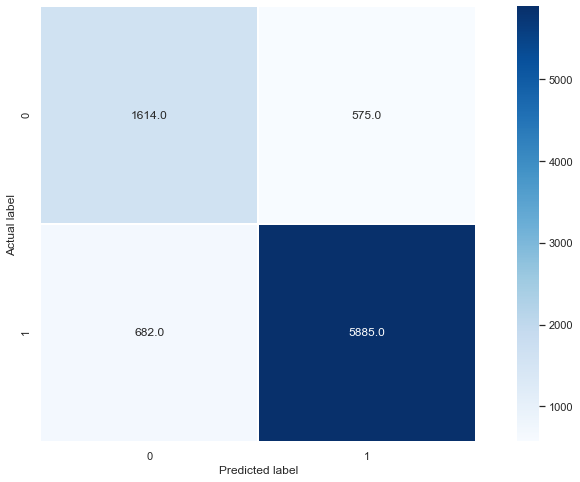

In [71]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, linewidth=0.5, annot=True, fmt=".1f", square=True, cmap="Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

In [46]:
gcv = GridSearchCV(lr, {"C": np.linspace(0.1,2), "class_weight": [None, "balanced"]}, 
                   cv=3, n_jobs=2, verbose=1)
gcv.fit(X_train, y_train)
gcv.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'C': 0.1, 'class_weight': 'balanced'}

In [47]:
ypred2 = gcv.best_estimator_.predict(X_test)
print(classification_report(y_test, ypred2))

              precision    recall  f1-score   support

        High       0.76      0.75      0.76      4441
         Low       0.75      0.76      0.75      4315

    accuracy                           0.76      8756
   macro avg       0.76      0.76      0.76      8756
weighted avg       0.76      0.76      0.76      8756



In [48]:
rds = RandomizedSearchCV(lr, {"C": np.linspace(0.1,2), "class_weight": [None, "balanced"]}, 
                   n_iter=10, cv=5, n_jobs=2, verbose=1)
rds.fit(X_train, y_train)
rds.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'class_weight': 'balanced', 'C': 0.13877551020408163}

In [49]:
ypred3 = rds.best_estimator_.predict(X_test)
print(classification_report(y_test, ypred3))

              precision    recall  f1-score   support

        High       0.76      0.75      0.76      4441
         Low       0.75      0.76      0.75      4315

    accuracy                           0.76      8756
   macro avg       0.76      0.76      0.76      8756
weighted avg       0.76      0.76      0.76      8756



Tuned Logistic regression model is giving same result... Should i boost?

In [109]:
from sklearn.tree import DecisionTreeClassifier

In [110]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred2 = dt.predict(X_test)

In [111]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

        High       0.86      0.88      0.87      2189
         Low       0.96      0.95      0.95      6567

    accuracy                           0.93      8756
   macro avg       0.91      0.91      0.91      8756
weighted avg       0.93      0.93      0.93      8756



Text(0.5, 48.5, 'Predicted label')

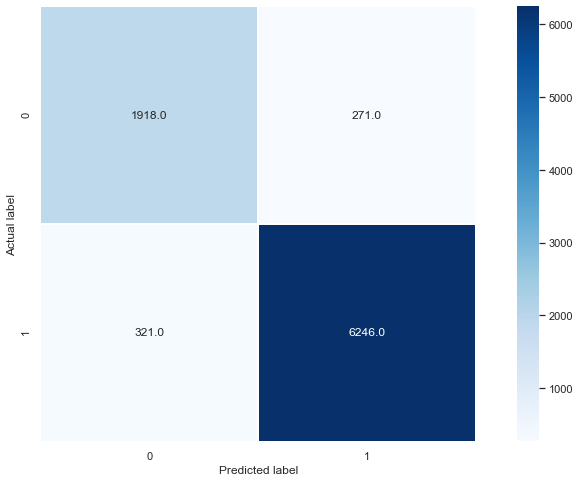

In [112]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, linewidth=0.5, annot=True, fmt=".1f", square=True, cmap="Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

In [113]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [114]:
grid = GridSearchCV(dt, {"max_depth": range(1,11), "min_samples_split": range(2,15,2)},
                   cv=5, n_jobs=2, verbose=1)

In [115]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'max_depth': range(1, 11),
                         'min_samples_split': range(2, 15, 2)},
             verbose=1)

In [116]:
grid.best_params_

{'max_depth': 10, 'min_samples_split': 2}

In [117]:
dtmodel = grid.best_estimator_
y_pred4 = dtmodel.predict(X_test)

In [118]:
dtmodel.score(X_train, y_train)

0.9385208452312964

In [119]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

        High       0.86      0.88      0.87      2189
         Low       0.96      0.95      0.96      6567

    accuracy                           0.93      8756
   macro avg       0.91      0.91      0.91      8756
weighted avg       0.93      0.93      0.93      8756



Random foest classifier

After finding the right model, use a pipeline
Search for traffic projects on github

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [121]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred6 = rfc.predict(X_test)

In [122]:
rfc.score(X_train, y_train)

0.938720731010851

In [123]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

        High       0.86      0.88      0.87      2189
         Low       0.96      0.95      0.96      6567

    accuracy                           0.93      8756
   macro avg       0.91      0.91      0.91      8756
weighted avg       0.93      0.93      0.93      8756



In [124]:
rsearch = RandomizedSearchCV(rfc, {"n_estimators": range(2,10), 
                          "max_depth": range(2, 20), 
                          "min_samples_split": range(2,12,2)}, 
                        cv=5, n_jobs=2, verbose=1)
rsearch.fit(X_train, y_train)
rsearch.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 8, 'min_samples_split': 4, 'max_depth': 16}

In [125]:
y_pred7 = rsearch.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

        High       0.85      0.87      0.86      2189
         Low       0.96      0.95      0.95      6567

    accuracy                           0.93      8756
   macro avg       0.91      0.91      0.91      8756
weighted avg       0.93      0.93      0.93      8756



Text(0.5, 48.5, 'Predicted label')

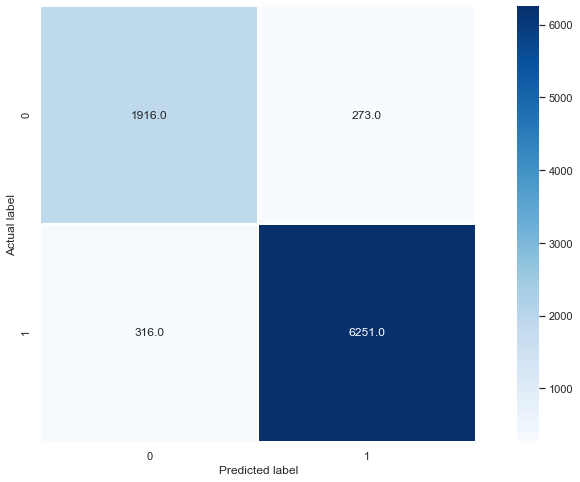

In [126]:
cm = confusion_matrix(y_test, y_pred6)
sns.heatmap(cm, linewidth=0.5, annot=True, fmt=".1f", square=True, cmap="Blues")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")